In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

%matplotlib inline

In [49]:
# --- 2. LOAD DATASET ---
data = pd.read_csv("day.csv")

# --- 3. SELECT RELEVANT COLUMNS ---
data = data[['dteday','season','mnth','holiday','workingday','weathersit','temp','atemp','cnt']]

# --- 4. PREPARE FEATURES AND TARGET ---
X = data[['season','mnth','holiday','workingday','weathersit','temp','atemp']]
y = data['cnt']

# --- 5. ONE-HOT ENCODING ---
categorical_cols = ['season','mnth','weathersit']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- SCALE FEATURES ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 6. CONVERT TO PURE NUMPY FLOAT ARRAYS (FIXES ALL TYPE ERRORS) ---
X = np.asarray(X_encoded, dtype=np.float64)
y = np.asarray(y, dtype=np.float64).reshape(-1, 1)



In [56]:
def predict(X, w, b):
    """Predict y using learned parameters w and b"""
    return np.dot(X, w) + b

def compute_cost(X, y, w, b):
    """Compute mean squared error cost"""
    m = X.shape[0]
    predictions = predict(X, w, b)
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

def compute_gradient(X, y, w, b):
    """Compute gradient for w and b"""
    m = X.shape[0]
    predictions = predict(X, w, b)
    error = predictions - y
    dj_dw = (1/m) * np.dot(X.T, error)
    dj_db = (1/m) * np.sum(error)
    return dj_dw, dj_db

def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    w = w_in.copy()
    b = b_in
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
    return w, b   



In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

alpha = 0.01
iterations = 500
r2_scores, rmse_scores, mae_scores = [], [], []
fold = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # initialiseer parameters
    n = X_train.shape[1]
    w = np.zeros((n,1))
    b = 0.0

    # train model
    w, b = gradient_descent(X_train, y_train, w, b, alpha, iterations)

    # predict
    y_pred = predict(X_test, w, b)
    
    # metrics
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Fold {fold}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    fold += 1

print("\n=== Average Model Performance Across 5 Folds ===")
print(f"Average R²   : {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Average RMSE : {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average MAE  : {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

Fold 1: R²=0.421, RMSE=1523.56, MAE=1310.32
Fold 2: R²=0.355, RMSE=1532.98, MAE=1288.60
Fold 3: R²=0.431, RMSE=1468.55, MAE=1213.99
Fold 4: R²=0.308, RMSE=1470.55, MAE=1178.91
Fold 5: R²=0.438, RMSE=1487.77, MAE=1291.21

=== Average Model Performance Across 5 Folds ===
Average R²   : 0.390 ± 0.051
Average RMSE : 1496.68 ± 26.81
Average MAE  : 1256.61 ± 50.91


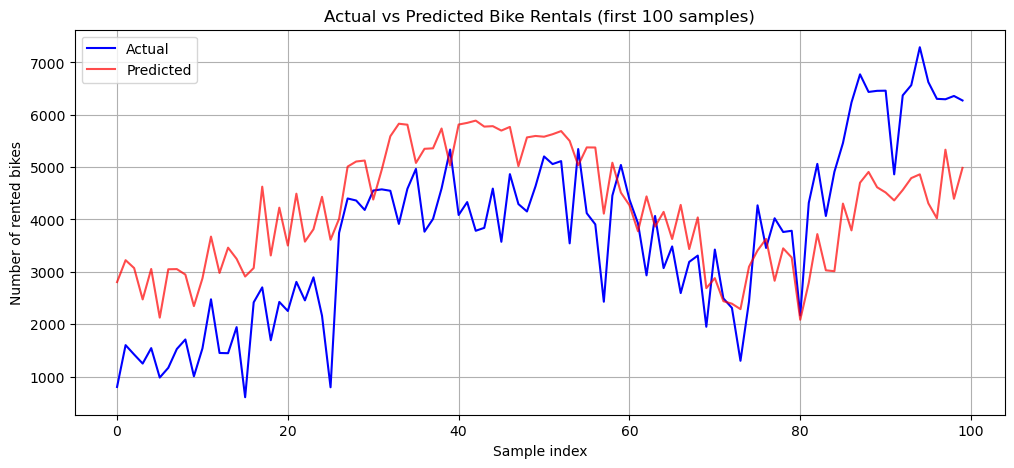

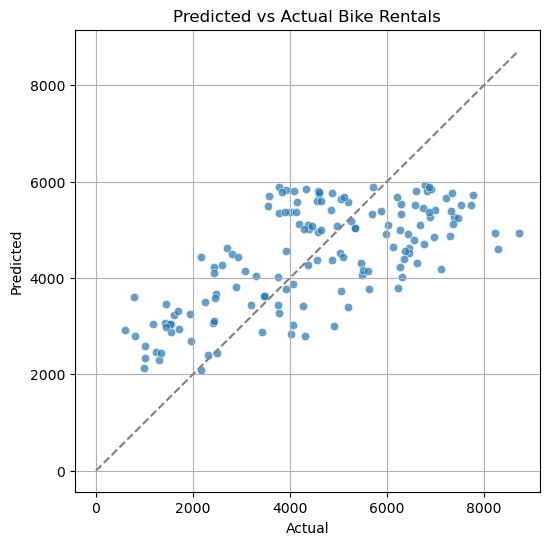

In [59]:
# --- 9. VISUALIZE RESULTS ---
plt.figure(figsize=(12,5))
plt.plot(y_test[:100], label="Actual", color='blue')
plt.plot(y_pred[:100], label="Predicted", color='red', alpha=0.7)
plt.title("Actual vs Predicted Bike Rentals (first 100 samples)")
plt.xlabel("Sample index")
plt.ylabel("Number of rented bikes")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten(), alpha=0.7)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], '--', color='gray')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Bike Rentals")
plt.grid(True)
plt.show()

In [33]:
# --- 10. PREDICTION FUNCTION ---
def predict_bike_rentals(season, mnth, holiday, workingday, weathersit, temp, atemp):
    """Make a prediction for custom input"""
    sample = pd.DataFrame({
        'season':[season],
        'mnth':[mnth],
        'holiday':[holiday],
        'workingday':[workingday],
        'weathersit':[weathersit],
        'temp':[temp],
        'atemp':[atemp]
    })
    sample_encoded = pd.get_dummies(sample, columns=categorical_cols, drop_first=True)
    for col in X_encoded.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    X_sample = sample_encoded[X_encoded.columns].values
    prediction = predict(X_sample, w, b)
    print(f"\nPredicted number of rentals: {prediction[0,0]:.0f} bikes")
    return prediction[0,0]

# --- 11. TEST PREDICTION ---
print("\nExample test prediction:")
example_pred = predict_bike_rentals(
    season=3,    # summer
    mnth=7,      # July
    holiday=0,   # not a holiday
    workingday=1,# working day
    weathersit=1,# clear weather
    temp=0.72,   # warm
    atemp=0.70   # feels warm
)


Example test prediction:

Predicted number of rentals: 4876 bikes


In [34]:
# --- 10. PREDICTION FUNCTION ---
def predict_bike_rentals(season, mnth, holiday, workingday, weathersit, temp, atemp):
    """Make a prediction for custom input"""
    sample = pd.DataFrame({
        'season':[season],
        'mnth':[mnth],
        'holiday':[holiday],
        'workingday':[workingday],
        'weathersit':[weathersit],
        'temp':[temp],
        'atemp':[atemp]
    })
    sample_encoded = pd.get_dummies(sample, columns=categorical_cols, drop_first=True)
    for col in X_encoded.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    X_sample = sample_encoded[X_encoded.columns].values
    prediction = predict(X_sample, w, b)
    print(f"\nPredicted number of rentals: {prediction[0,0]:.0f} bikes")
    return prediction[0,0]

# --- 11. TEST PREDICTION ---
print("\nExample test prediction:")
example_pred = predict_bike_rentals(
    season=1,
    mnth=1,
    holiday=0,
    workingday=1,
    weathersit=3,
    temp=0.22,
    atemp=0.25
)



Example test prediction:

Predicted number of rentals: 2498 bikes
